<a href="https://colab.research.google.com/github/jeromepatel/GANs-experiments/blob/main/Generating_Cifar_10_with_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.__version__
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [ ]:
!pip install imageio
!pip install mitdeeplearning
import mitdeeplearning as mdl

     |████████████████████████████████| 2.1MB 4.9MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.1.2-cp36-none-any.whl size=2114586 sha256=28fcd5ef9647fa59ef528857294956ec760a37186d0a1d11bb7d94030ba0dc3f
  Stored in directory: /root/.cache/pip/wheels/27/e1/73/5f01c787621d8a3c857f59876c79e304b9b64db9ff5bd61b74
Successfully built mitdeeplearning


In [ ]:
import glob
#import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import PIL
from tensorflow.keras import layers
 
from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  # foundation for 4x4 image
  n_nodes=256*4*4
  model.add(layers.Dense(n_nodes, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Reshape((4, 4, 256)))
  # upsample to 8x8
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.ReLU())
  # upsample to 16x16
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.ReLU())
  # upsample to 32x32
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
  #model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  # output layer
  model.add(layers.Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096)              16384     
_________________________________________________________________
re_lu (ReLU)                 (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 128)        

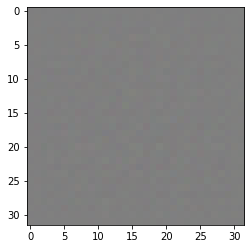

In [ ]:
generator = make_generator_model()
 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
#plt.imshow(generated_image[0, :, :, :], cmap='gray')
#plt.imshow(generated_image[0,:,:])
#plt.imshow((generated_image[0]*127.5+127.5).numpy().astype('int'))
k = (generated_image[0]+1.0)/2.0
plt.imshow(k,vmax = 1, vmin = 0)
generator.summary()

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    # normal
    model.add(layers.Conv2D(64, (3,3), padding='same', input_shape=[32,32,3 ]))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))
    # downsample
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    #model.add(layers.Dropout(0.3))
    # downsample
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    #model.add(layers.Dropout(0.3))
    # downsample
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    #model.add(layers.Dropout(0.3))
    layers.GlobalMaxPooling2D(),
    # classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    #model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)
discriminator.summary()

tf.Tensor([[-0.0002497]], shape=(1, 1), dtype=float32)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________

In [ ]:
# Define loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# we dont use these losses
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,0.5)
 
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,0.5)

In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16
 
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
#loss_history = mdl.util.LossHistory(smoothing_factor=0.95) # to record the evolution of the loss
#plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')
gen_loss = []
desc_loss = []

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(real_images):
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal([BATCH_SIZE, noise_dim])
    # Decode them to fake images
    generated_images = generator(random_latent_vectors)
    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)
 
    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((BATCH_SIZE, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(labels.shape)
 
    # Train the discriminator
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = cross_entropy(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
 
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(BATCH_SIZE, noise_dim))
    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((BATCH_SIZE, 1))
    
    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors))
        g_loss = cross_entropy(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    return d_loss, g_loss, generated_images

In [ ]:
def train(dataset, epochs):
    start = time.time()
    # In practice you need at least 100 epochs .
    save_dir = "./"
 
    for epoch in range(epochs):
        print("\nStart epoch", epoch)
 
        for step, real_images in enumerate(dataset):
            # Train the discriminator & generator on one batch of real images.
            d_loss, g_loss, generated_images = train_step(real_images)
            # Logging.
            if step % 200 == 0:
                # Print metrics
                print("discriminator loss at step %d: %.2f" % (step, d_loss))
                print("adversarial loss at step %d: %.2f" % (step, g_loss))
                desc_loss.append("%.2f"%(d_loss))
                gen_loss.append("%.2f"%(g_loss))
        print ('Time since start epoch {} is {} min '.format(epoch + 1, (time.time()-start)/60))
 
        # Generate after each epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                            epoch,
                            seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
 
  fig = plt.figure(figsize=(4,4))
 
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i]+1.0)/2.0,vmax=1.0,vmin= 0,interpolation='nearest')
      plt.axis('off')
 
  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

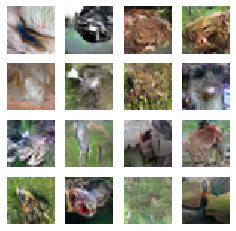

In [ ]:
try:
    train(train_dataset, EPOCHS)
except KeyboardInterrupt:
    print('Cant you just wait to complete the training')

In [ ]:
desc_loss
loss_lst = list(map(float, desc_loss))
loss_lst2 = list(map(float, gen_loss))
#plt.imshow((generator (seed)[0]+1.0)/2.0,vmin = -1,vmax= 1)

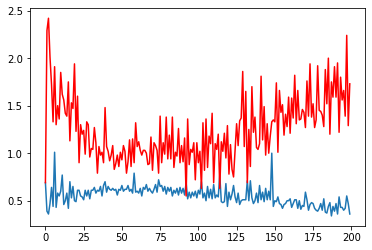

In [ ]:
from matplotlib import pyplot as plt
plt.plot(loss_lst)
plt.plot(loss_lst2, c='r')
plt.show()

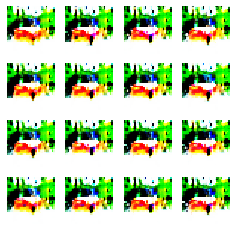

In [ ]:
generate_and_save_images(generator,-2,seed)

In [ ]:
import tqdm

#@title Default title text
# Rebuild the CNN model
cnn_model = build_cnn_model()

batch_size = 128
loss_history = mdl.util.LossHistory(smoothing_factor=0.95) # to record the evolution of the loss
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2) # define our optimizer

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for idx in tqdm(range(0, train_images.shape[0], batch_size)):
  # First grab a batch of training data and convert the input images to tensors
  (images, labels) = (train_images[idx:idx+batch_size], train_labels[idx:idx+batch_size])
  images = tf.convert_to_tensor(images, dtype=tf.float32)

  # GradientTape to record differentiation operations
  with tf.GradientTape() as tape:
    #'''TODO: feed the images into the model and obtain the predictions'''
    logits = cnn_model(images)

    #'''TODO: compute the categorical cross entropy loss
    loss_value = tf.keras.backend.sparse_categorical_crossentropy(labels, logits) 

  loss_history.append(loss_value.numpy().mean()) # append the loss to the loss_history record
  plotter.plot(loss_history.get())

  # Backpropagation
  '''TODO: Use the tape to compute the gradient against all parameters in the CNN model.
      Use cnn_model.trainable_variables to access these parameters.''' 
  grads = tape.gradient(loss_value, cnn_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, cnn_model.trainable_variables))



In [ ]:
#adapted from https://machinelearningmastery.com for comparison
# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/390, d1=0.690, d2=0.696 g=0.691
>1, 2/390, d1=0.627, d2=0.699 g=0.689
>1, 3/390, d1=0.558, d2=0.705 g=0.683
>1, 4/390, d1=0.462, d2=0.719 g=0.671
>1, 5/390, d1=0.350, d2=0.746 g=0.653
>1, 6/390, d1=0.237, d2=0.785 g=0.635
>1, 7/390, d1=0.139, d2=0.810 g=0.642
>1, 8/390, d1=0.088, d2=0.768 g=0.693
>1, 9/390, d1=0.062, d2=0.688 g=0.762
>1, 10/390, d1=0.042, d2=0.631 g=0.818
>1, 11/390, d1=0.039, d2=0.621 g=0.840
>1, 12/390, d1=0.029, d2=0.659 g=0.825
>1, 13/390, d1=0.033, d2=0.710 g=0.801
>1, 14/390, d1=0.036, d2=0.731 g=0.795
>1, 15/390, d1=0.032, d2=0.698 g=0.811
>1, 16/390, d1=0.055, d2=0.658 g=0.843
>1, 17/390, d1=0.086, d2=0.636 g=0.864
>1, 18/390, d1=0.146, d2=0.642 g=0.860
>1, 19/390, d1=0.140, d2=0.676 g=0.839
>1, 20/390, d1=0.069, d2=0.713 g=0.856
>1, 21/390, d1=0.088, d2=0.687 g=0.877
>1, 22/390, d1=0.156, d2=0.685 g=0.851
>1, 23/390, d1=0.081, d2=0.669 g=0.872
>1, 24/390, d1=0.069, d2=0.613 g=0.905
>1, 25/390, d1=0.046, d2=0.570 g=0.921
>1, 26/390, d1=0.028, d2=0.566 g=0

KeyboardInterrupt: ignored

In [ ]:
print(generator.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 128)      

In [ ]:
filename = 'generator_model_%03d.h5' % (100)
generator.save(filename)